# Test with Stanza parsing

In [ ]:
import stanza
# stanza.download('en') # download English model
nlp = stanza.Pipeline('en', processors='tokenize,mwt,pos,lemma,depparse') # initialize English neural pipeline

In [ ]:
sents = [
        # 'he sleeps.',
        # 'he sleeps his opponent in the tournament.', # Develope new slots

        # 'he is a big bad wolf', # Multiple similar slots of one target word
        # 'he runs the company and the firm' # Multiple similar slots of one target word

        # 'This is Microsoft Windows operating system.', # Changing POS from N -> ProN
        # 'This is the doors and the windows',
        # 'Windows cannot compete against MacOS',

        # 'This is a gay day.',
        # 'I am a gay!',
        # 'You are such a gay mofo!!!',

        "'I went into a caf to warm up , this is the coldest February 14th in 17 years it said on the weather , and drank three espressos before I noticed the sign on the counter  --  Apartment for Rent . The apartment was above the caf  --  three hundred a month . The man did n't want to show me at first .'",        
        ]

In [ ]:
import stanza

nlp = stanza.Pipeline("en")   # or another language
doc = nlp("She was running quickly.")

for sent in doc.sentences:
    for word in sent.words:
        print(word.text, word.upos, word.feats)

In [ ]:
for sent in sents:
    doc = nlp(sent) # run annotation over a sentence
    print('sentence:', sent)
    # print(doc)
    # print(doc.entities)
    print(*[f'word: {word.text}\tlemma: {word.lemma}\tpos: {word.pos}\tid: {word.id}\thead id: {word.head}\thead: {sent.words[word.head-1].text if word.head > 0 else "root"}\tdeprel: {word.deprel}' for sent in doc.sentences for word in sent.words], sep='\n')
    print('end')

# Input

In [8]:
%load_ext autoreload
%autoreload 2

import re
import os

pattern = re.compile(
    r'([^\t]+)\t'      # word form
    r'([^\t]+)\t'      # lemma
    r'([^\t])[^\t]*\t' # POS (UPOS or XPOS)
    r'([^\t]+)\t'      # ID
    r'([^\t]+)\t'      # HEAD
    r'([^\t]+)'        # DEPREL
)

target_lemma = 'air'
target_pos = 'N'

# RSC
period = '1750-1819'
corpus_folder = f'/home/volt/bach/pilot_data/RSC/1750-1819_che_half_decades'
output_folder = f'/home/volt/bach/SynFlow/output/{target_lemma}-{target_pos}-{period}'
output_explorer = f'{output_folder}/Explorer'
output_embedding = f'{output_folder}/Embedding'
input_SCD = f'/home/volt/bach/SynFlow/input/SCD/{target_lemma}-{target_pos}-{period}'

# COHA
# period = '1900-2000'
# corpus_folder = f'/home/volt/bach/pilot_data/COHA'
# output_folder = f'/home/volt/bach/SynFlow/output/{target_lemma}-{target_pos}-{period}'
# output_explorer = f'{output_folder}/Explorer'
# output_embedding = f'{output_folder}/Embedding'

os.makedirs(output_explorer, exist_ok=True)
os.makedirs(output_embedding, exist_ok=True)
os.makedirs(input_SCD, exist_ok=True)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Explore the vocab freq

In [9]:
from SynFlow.Explorer.vocab_freq import gen_lemma_freq

In [10]:
# modes: 'lemma_pos', 'lemma_pos_init', or 'lemma_deprel'
gen_lemma_freq(corpus_folder, 
               '/home/volt/bach/pilot_data/RSC/1750-1819_che_half_decades_vocab',
               file_ext='.txt', mode='lemma_pos_init')

# Explore the distribution of different syntactic slots from the corpus

## Slot-path Explorer

[1750] Collected 705 context links, 34 distinct arguments.


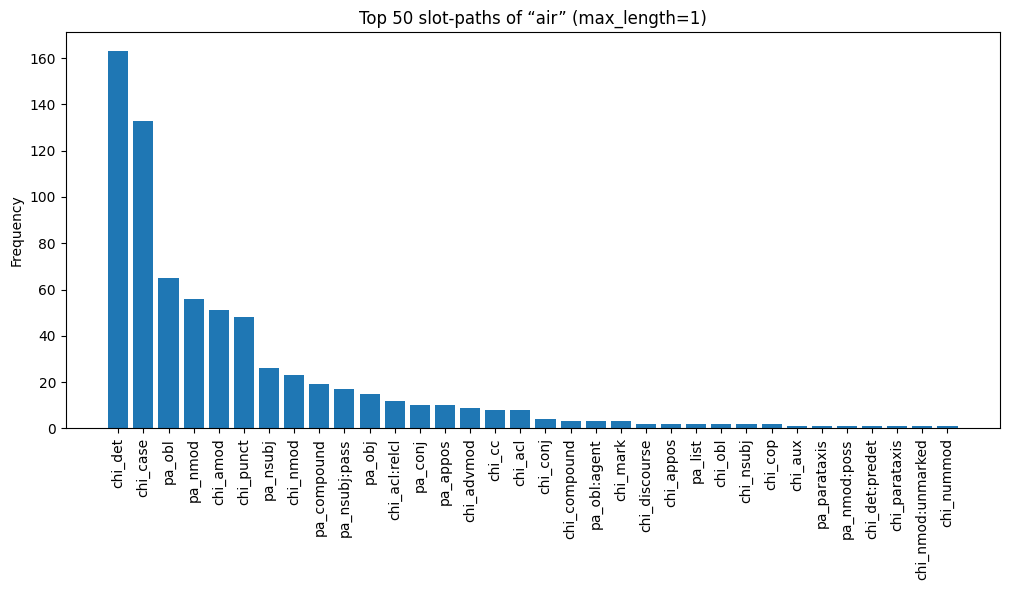

[1755] Collected 820 context links, 29 distinct arguments.


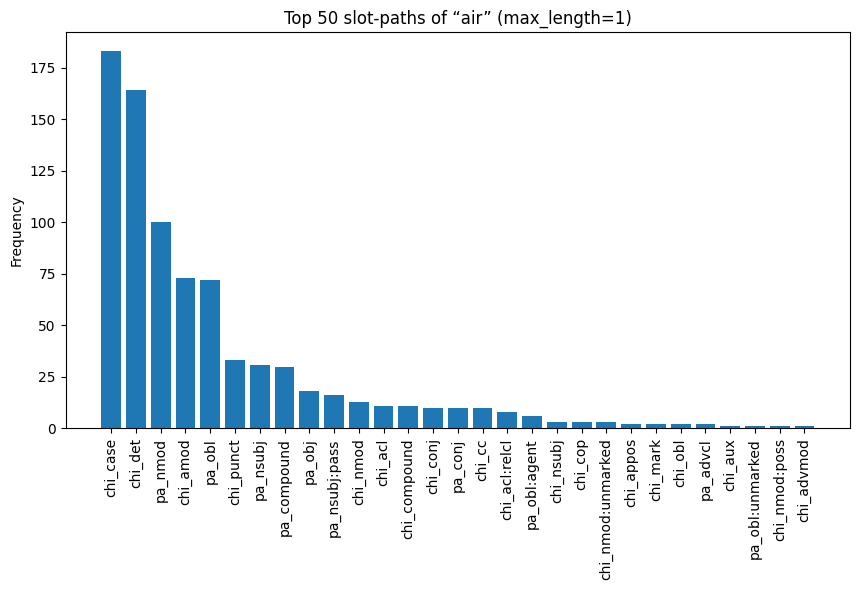

[1760] Collected 374 context links, 21 distinct arguments.


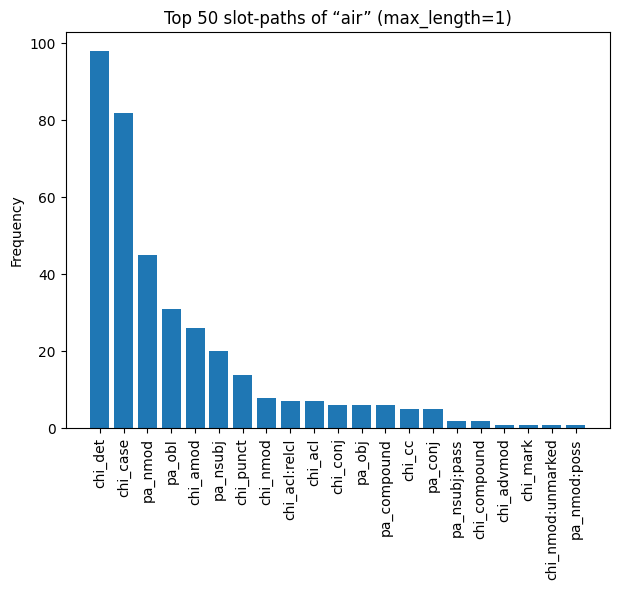

[1765] Collected 2924 context links, 39 distinct arguments.


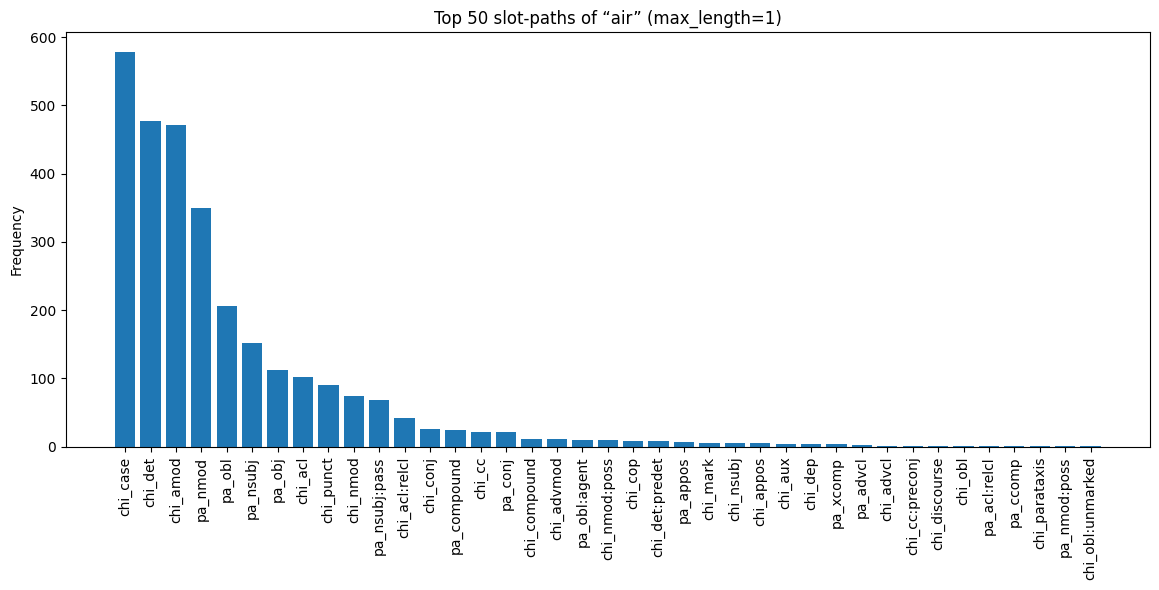

[1770] Collected 4551 context links, 45 distinct arguments.


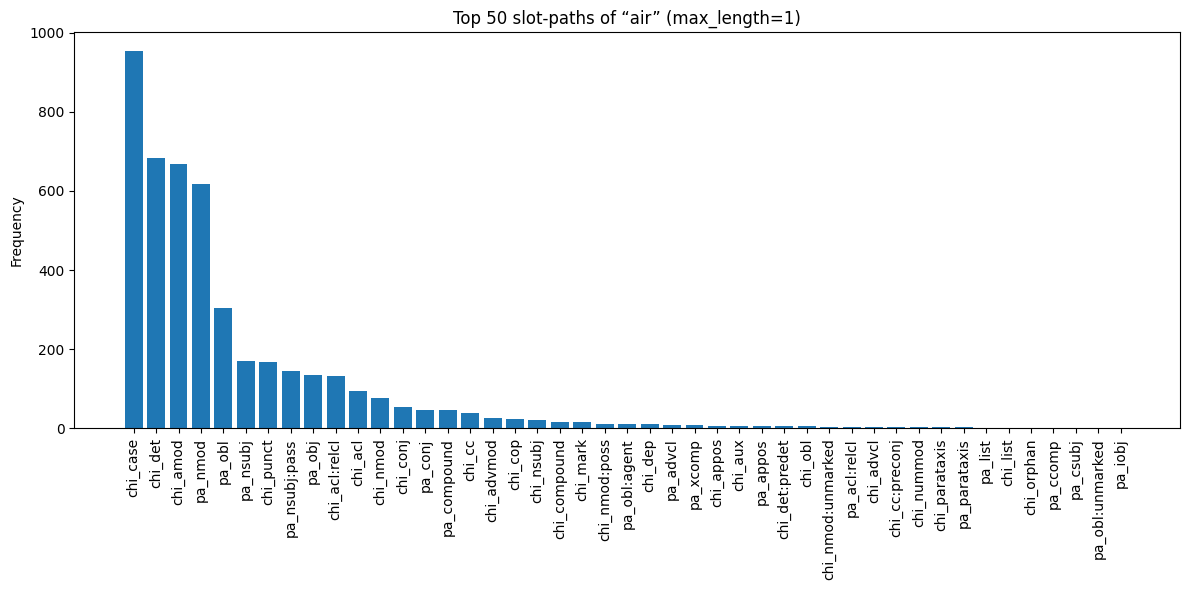

[1775] Collected 5264 context links, 44 distinct arguments.


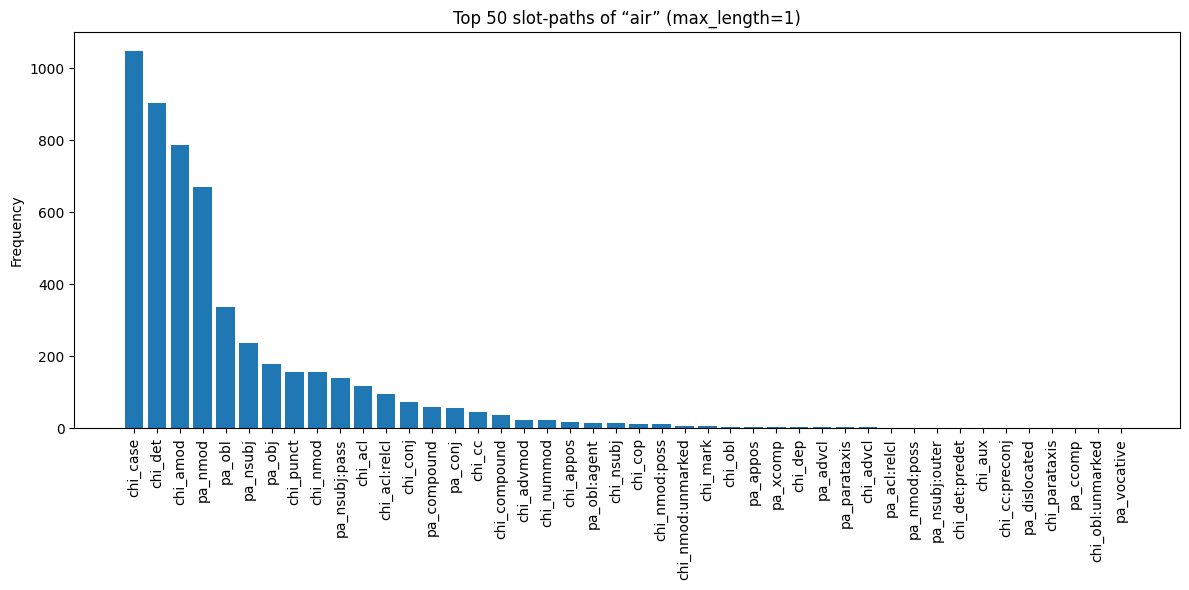

[1780] Collected 9045 context links, 50 distinct arguments.


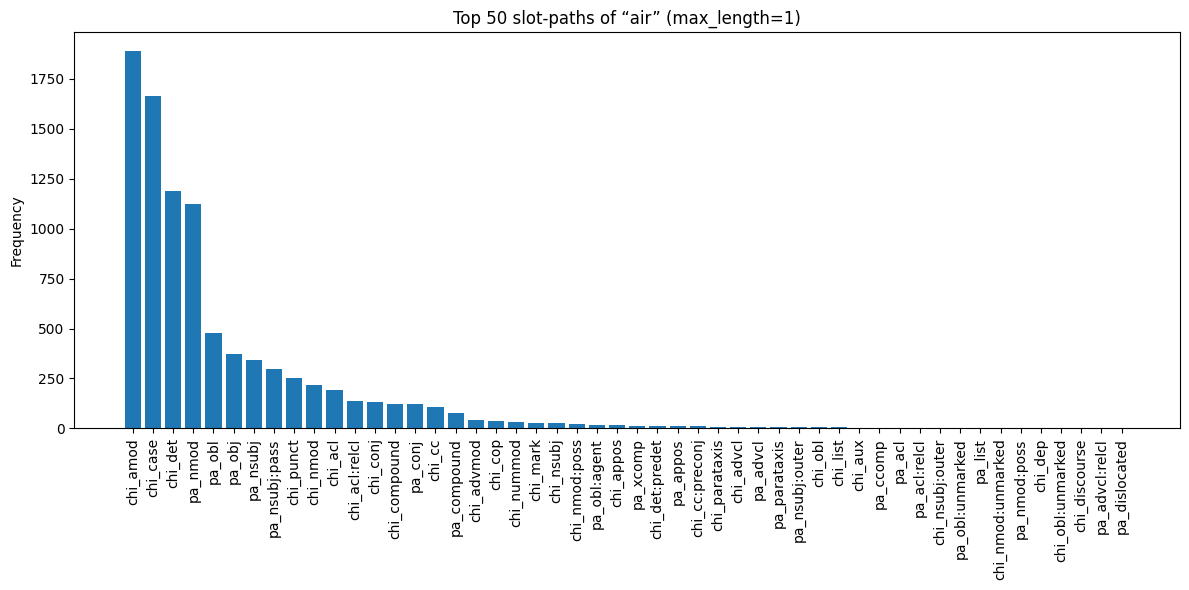

[1785] Collected 7450 context links, 44 distinct arguments.


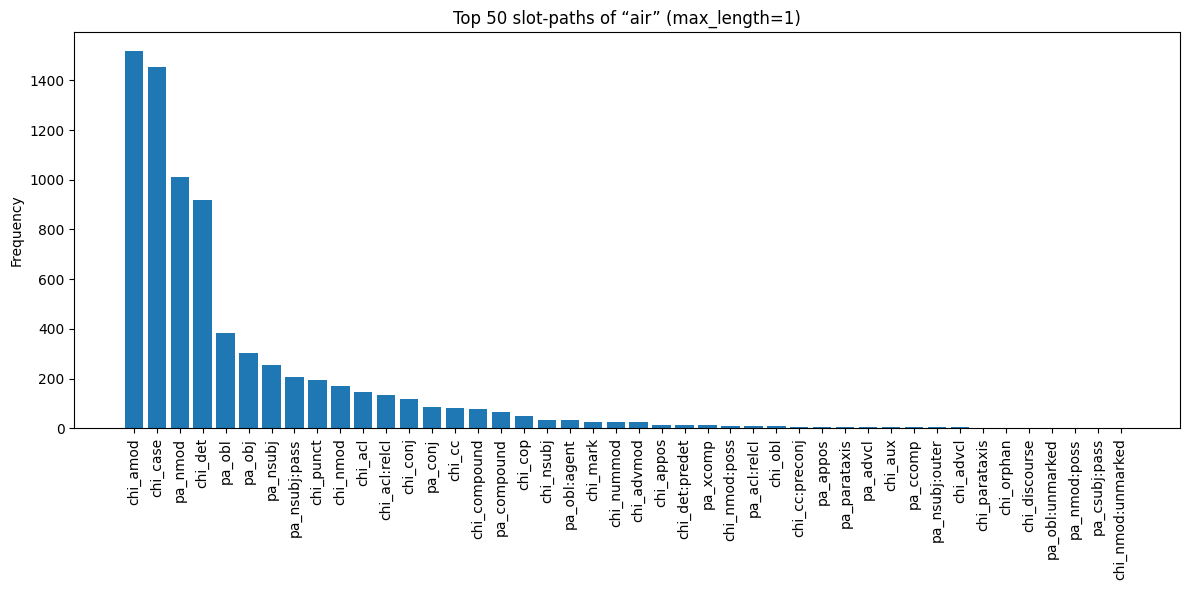

[1790] Collected 4742 context links, 42 distinct arguments.


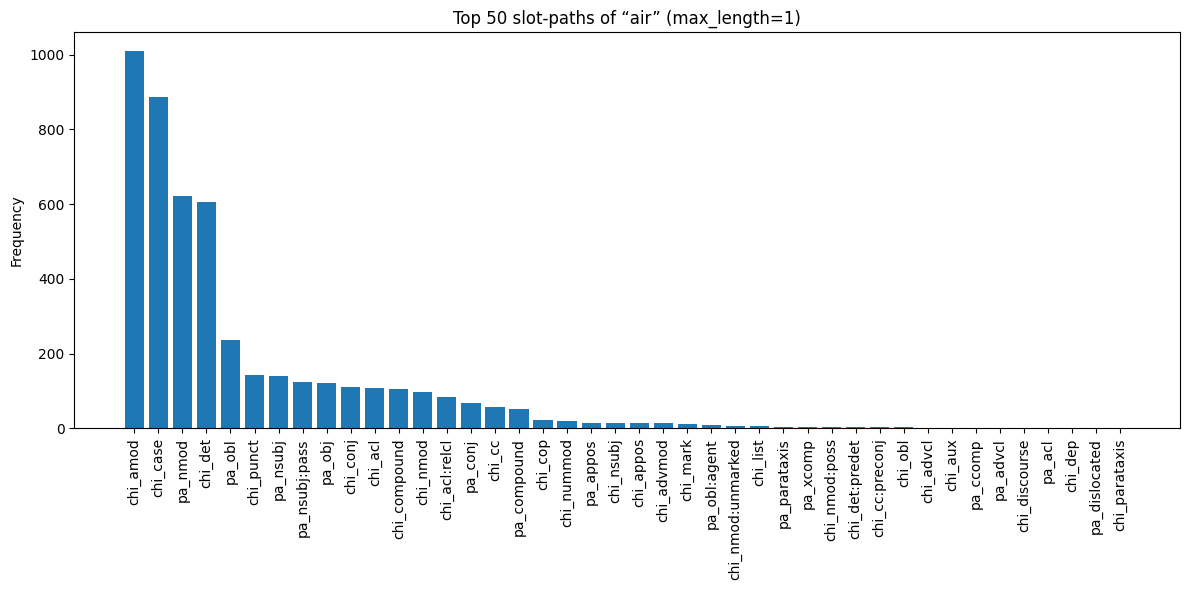

[1795] Collected 882 context links, 34 distinct arguments.


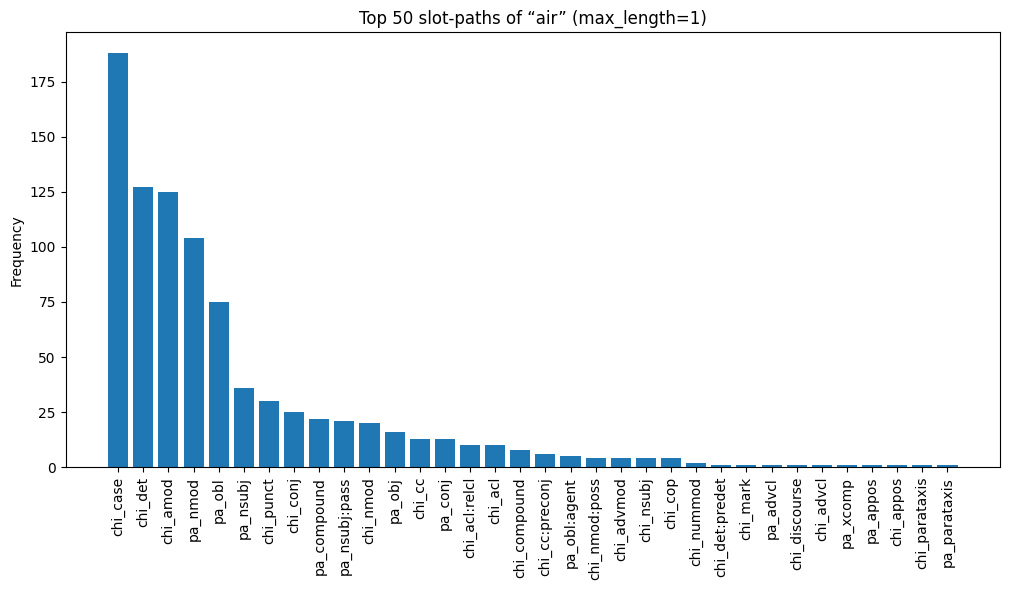

[1800] Collected 1784 context links, 39 distinct arguments.


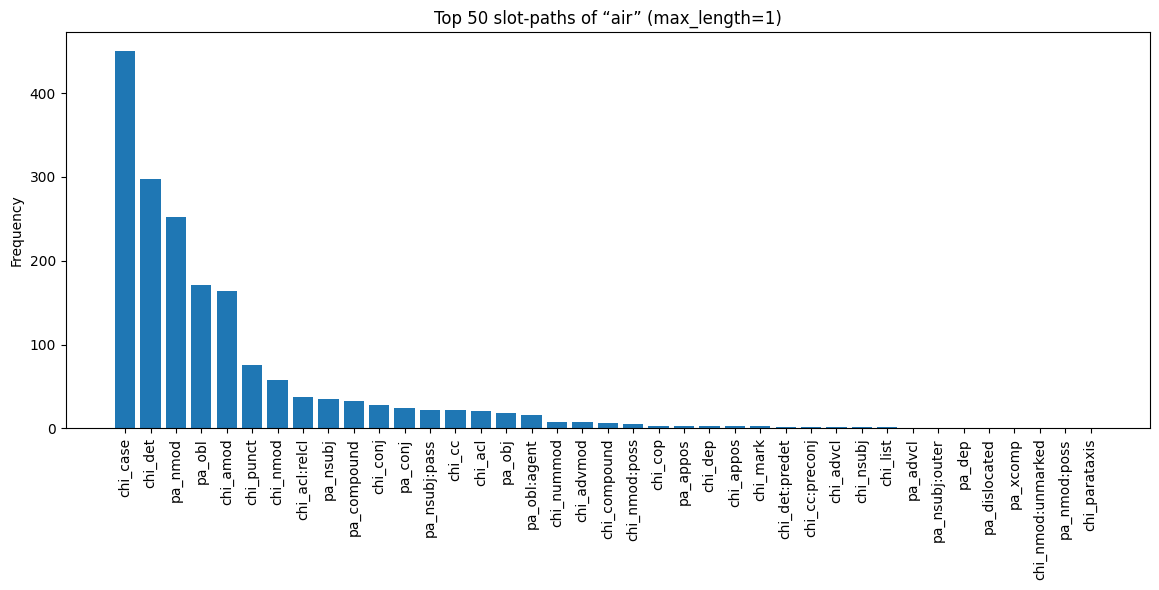

[1805] Collected 977 context links, 30 distinct arguments.


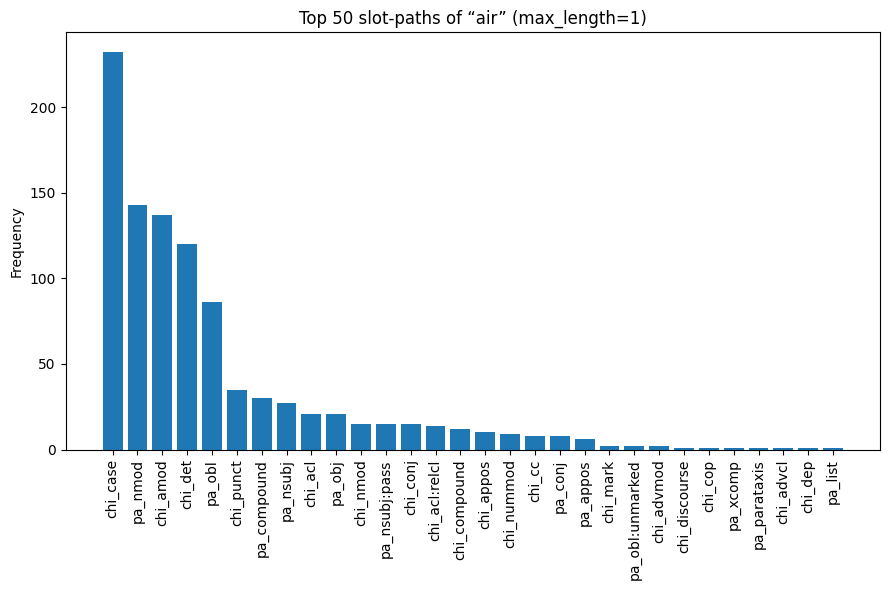

[1810] Collected 786 context links, 32 distinct arguments.


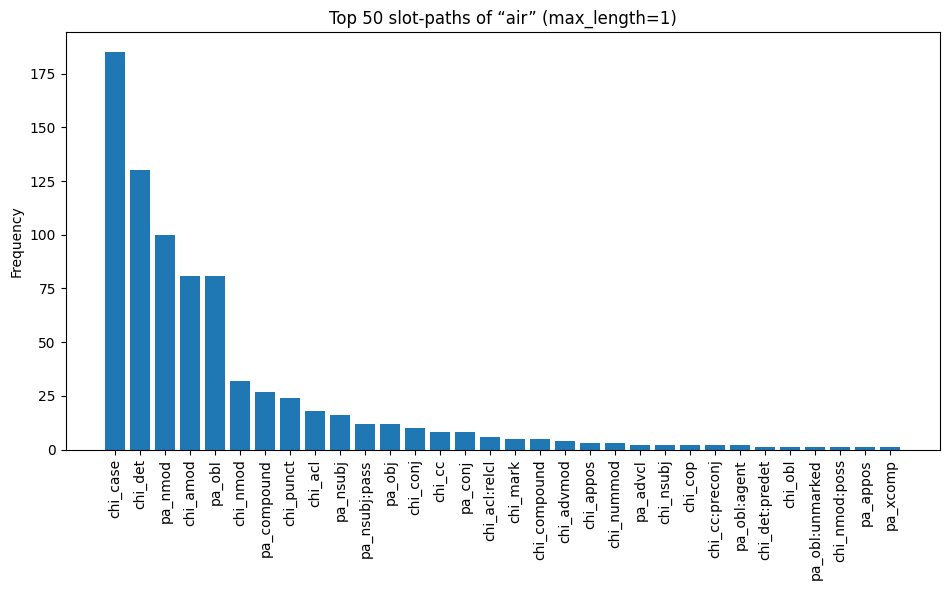

[1815] Collected 1121 context links, 30 distinct arguments.


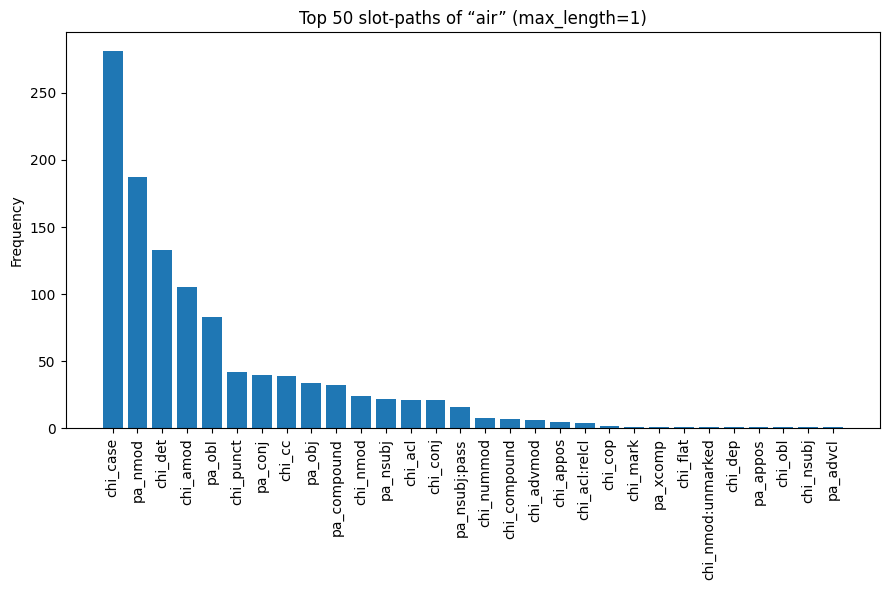

Saved slot-path frequencies to: /home/volt/bach/SynFlow/output/air-N-1750-1819/Explorer/air_N_spaths.json


In [11]:
from SynFlow.Explorer import spath_explorer
dist = spath_explorer(
    corpus_folder=corpus_folder,
    target_lemma=target_lemma,
    target_pos=target_pos,
    max_length=1,
    top_n=50,
    pattern=pattern,
    output_folder=output_explorer
)

## Unique Argument Combination Explorer

[1750] Total instances: 226, distinct patterns: 72


/home/local/bach/SynFlow/SynFlow/Explorer/spath_comb_explorer.py:157: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


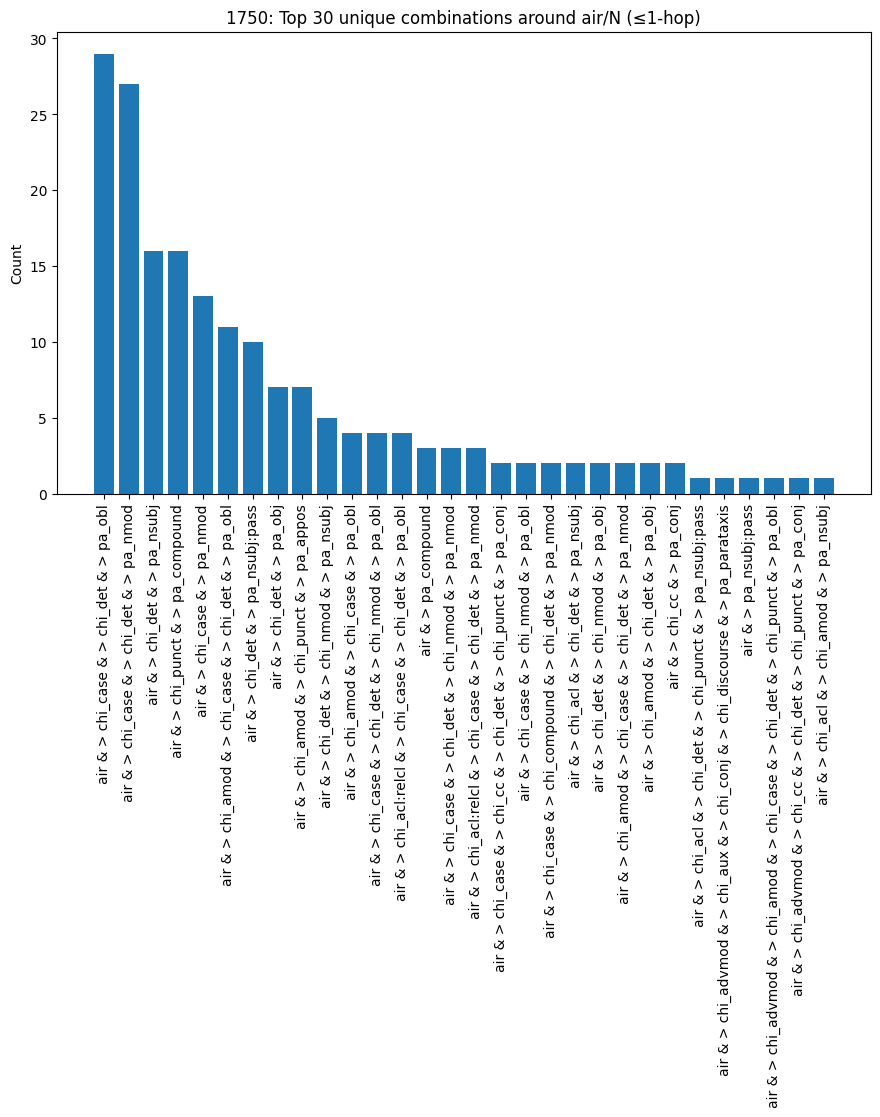

[1755] Total instances: 287, distinct patterns: 73


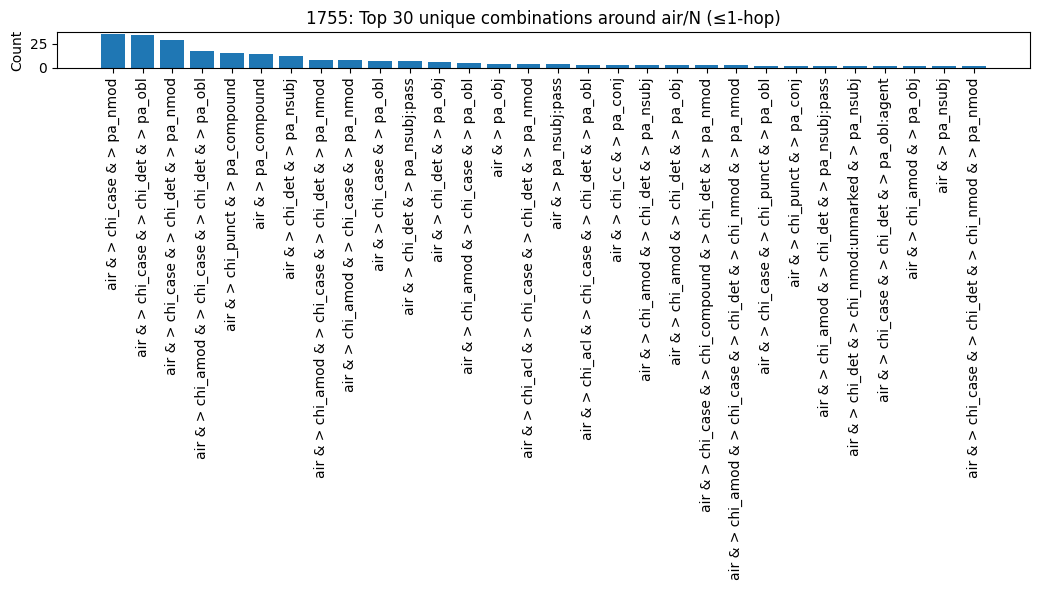

[1760] Total instances: 117, distinct patterns: 44


/home/local/bach/SynFlow/SynFlow/Explorer/spath_comb_explorer.py:157: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


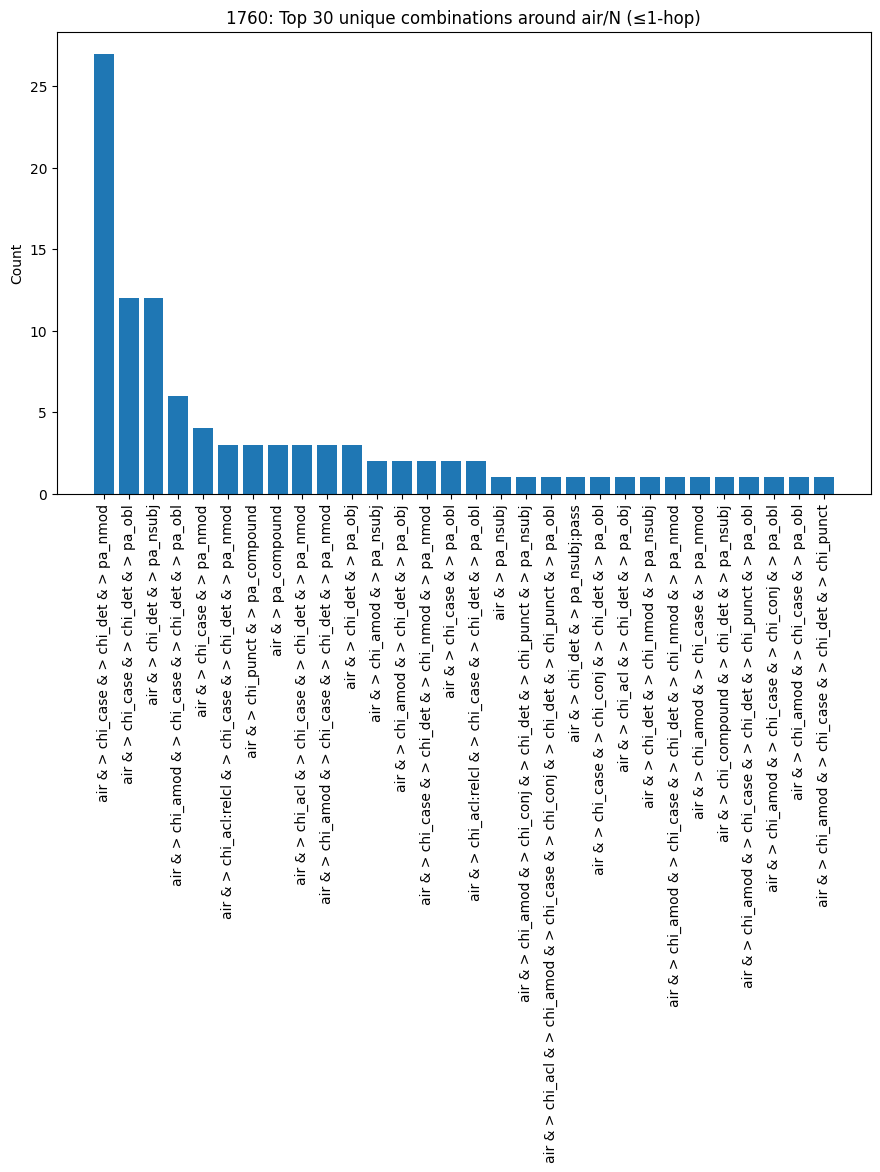

[1765] Total instances: 967, distinct patterns: 177


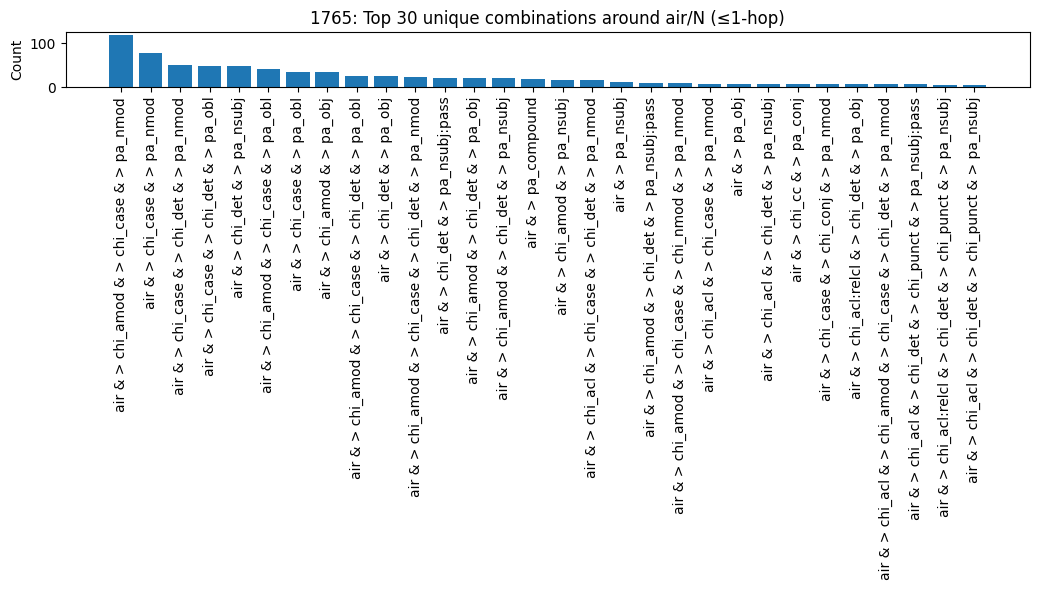

[1770] Total instances: 1516, distinct patterns: 247


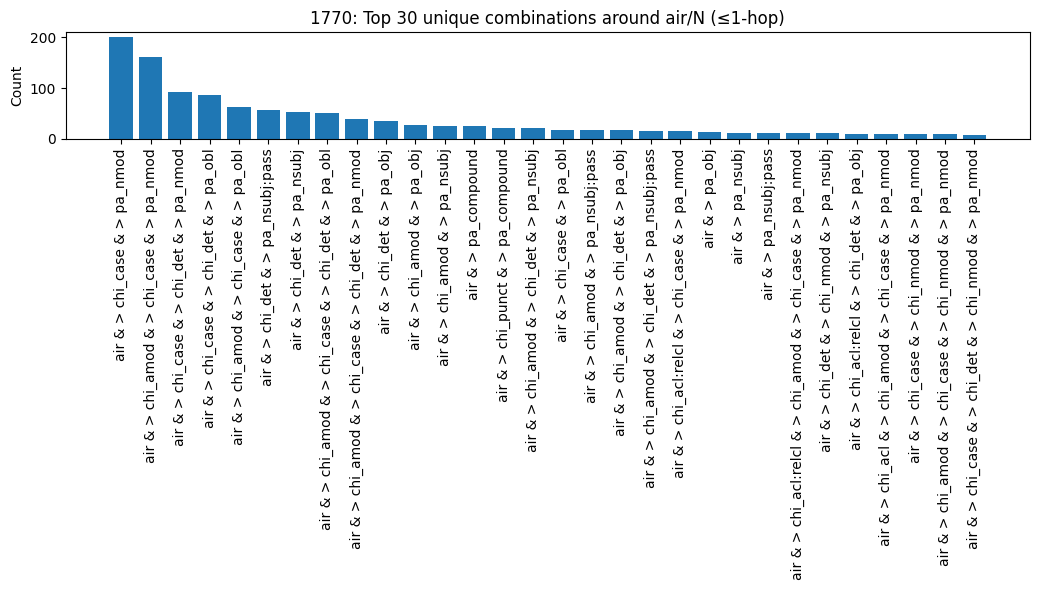

[1775] Total instances: 1721, distinct patterns: 271


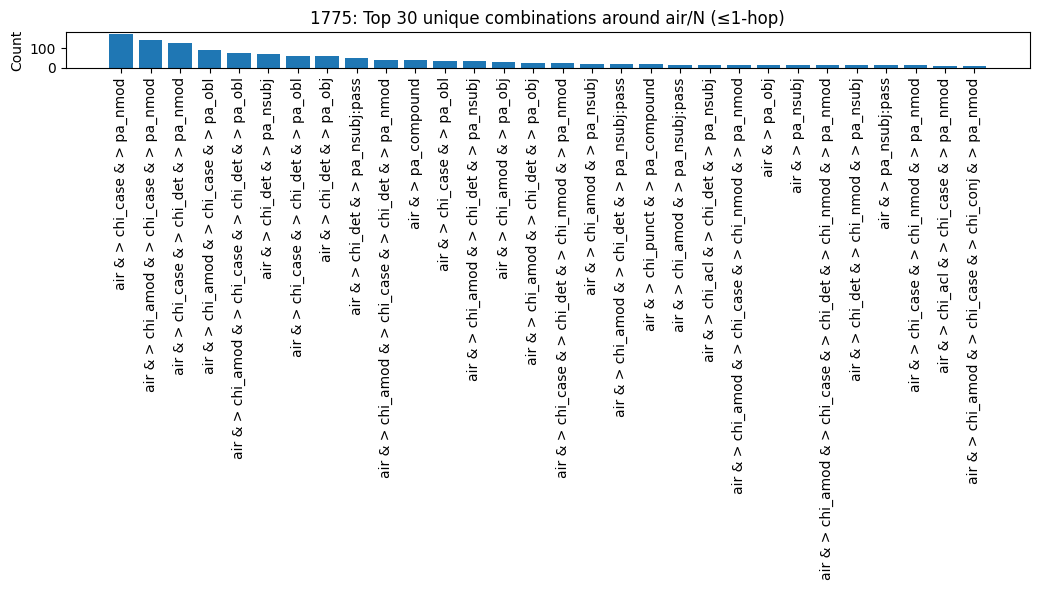

[1780] Total instances: 2900, distinct patterns: 395


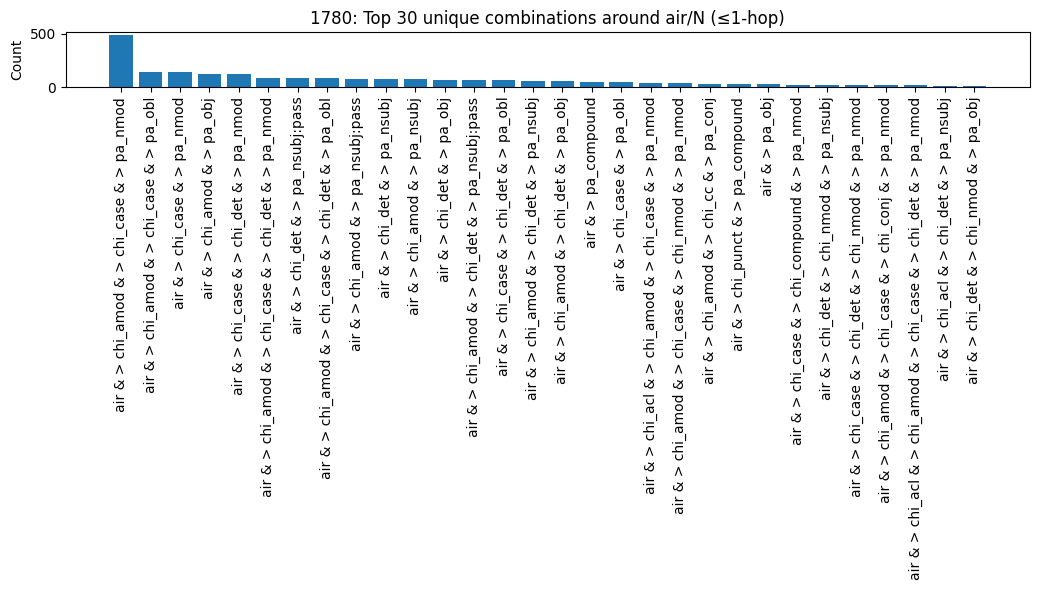

[1785] Total instances: 2405, distinct patterns: 341


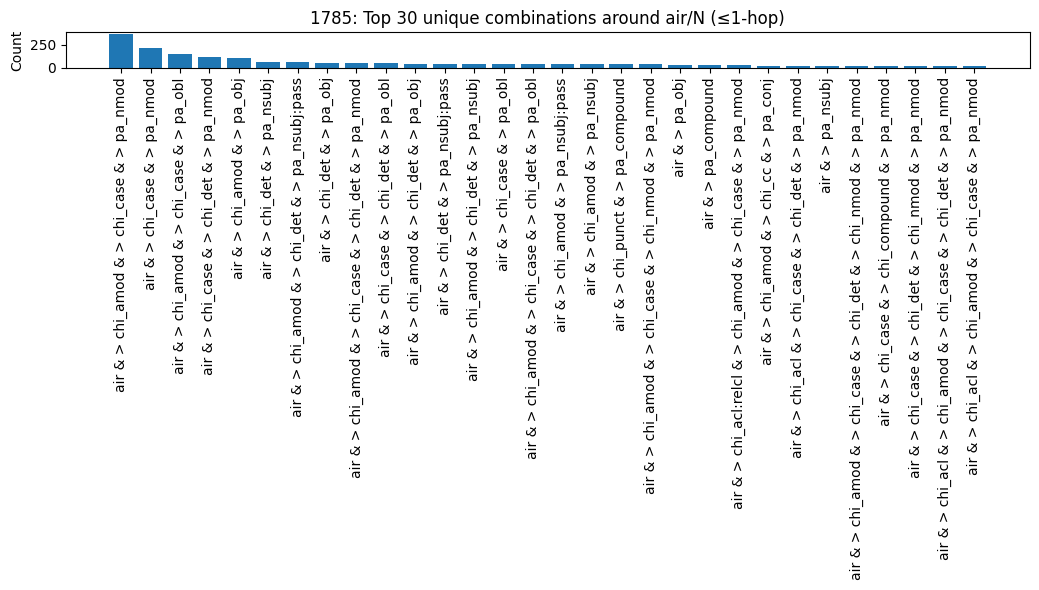

[1790] Total instances: 1414, distinct patterns: 292


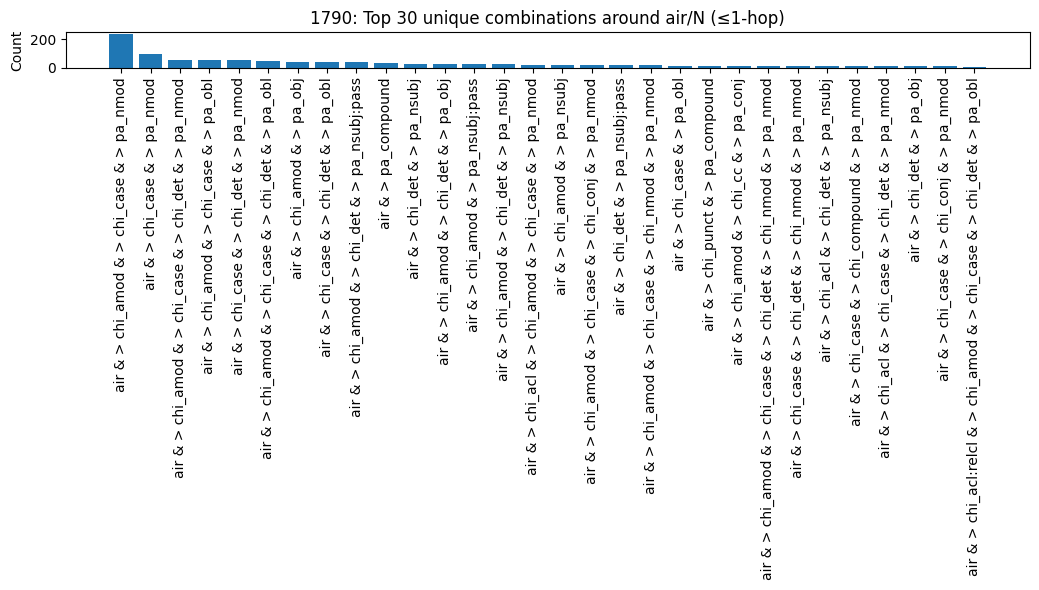

[1795] Total instances: 298, distinct patterns: 95


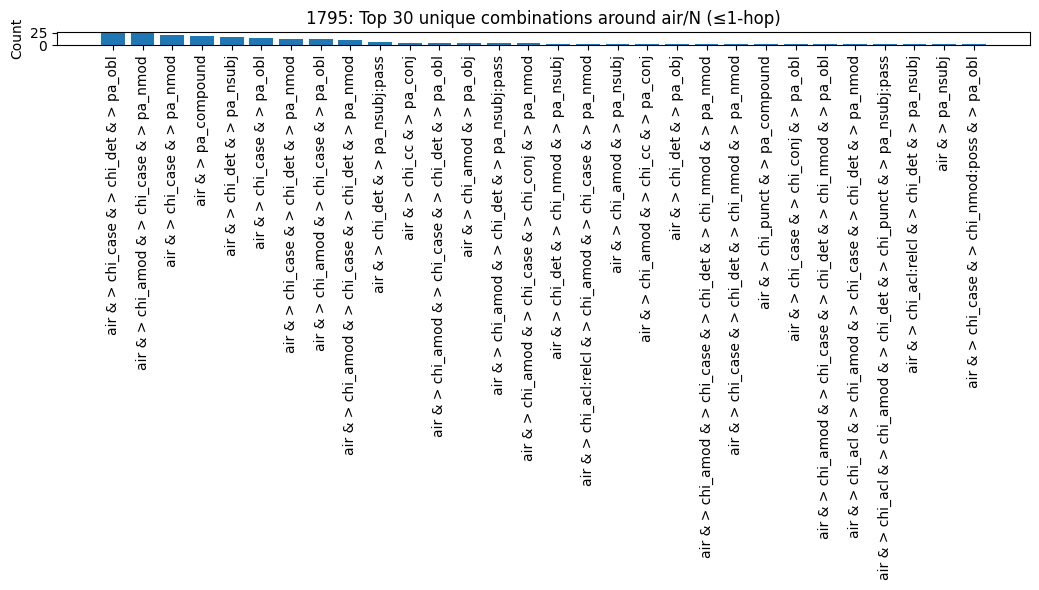

[1800] Total instances: 581, distinct patterns: 133


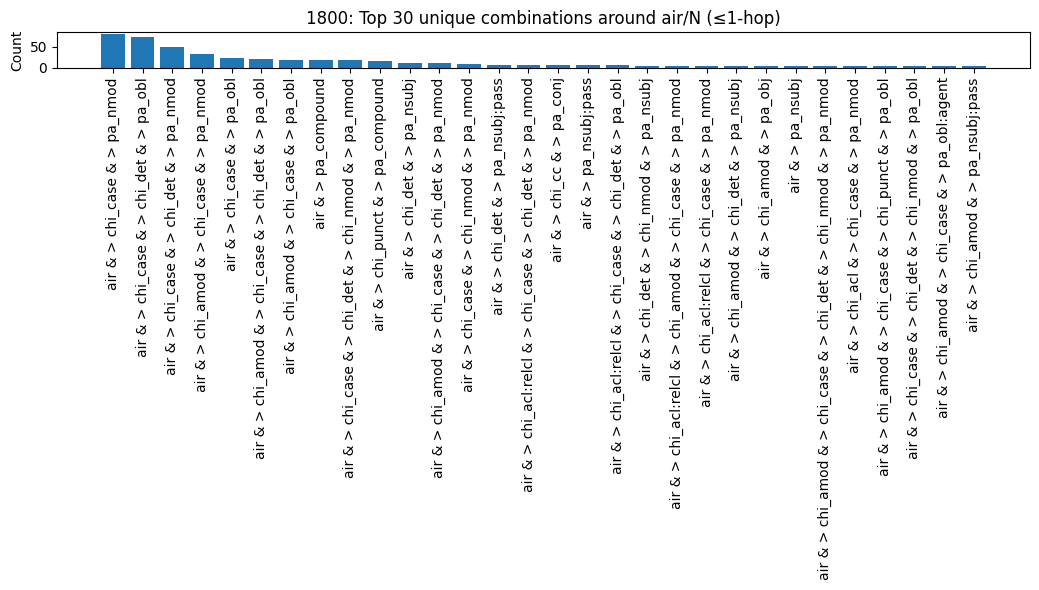

[1805] Total instances: 344, distinct patterns: 94


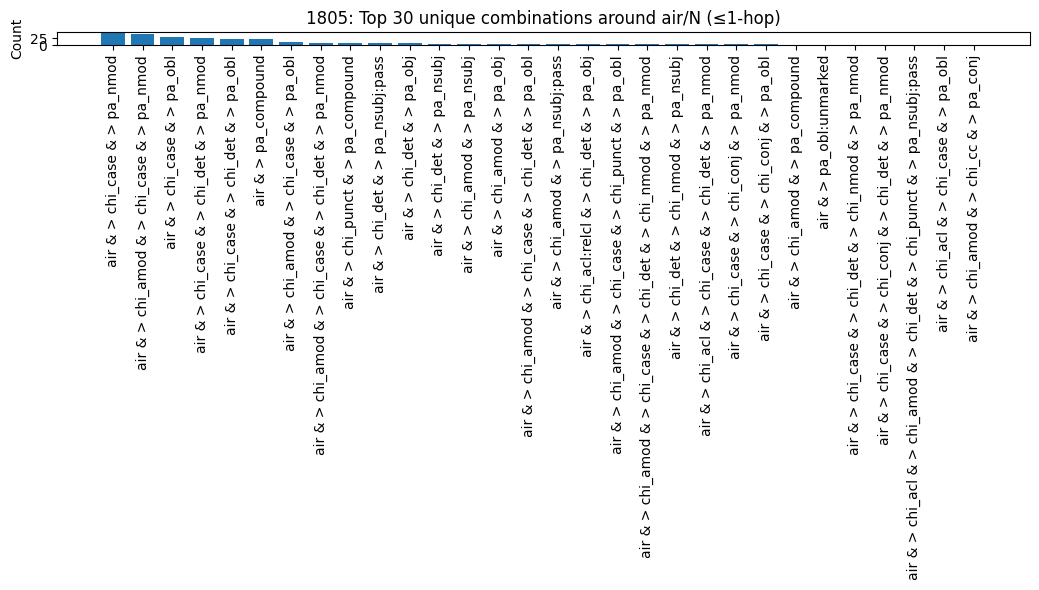

[1810] Total instances: 265, distinct patterns: 77


/home/local/bach/SynFlow/SynFlow/Explorer/spath_comb_explorer.py:157: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


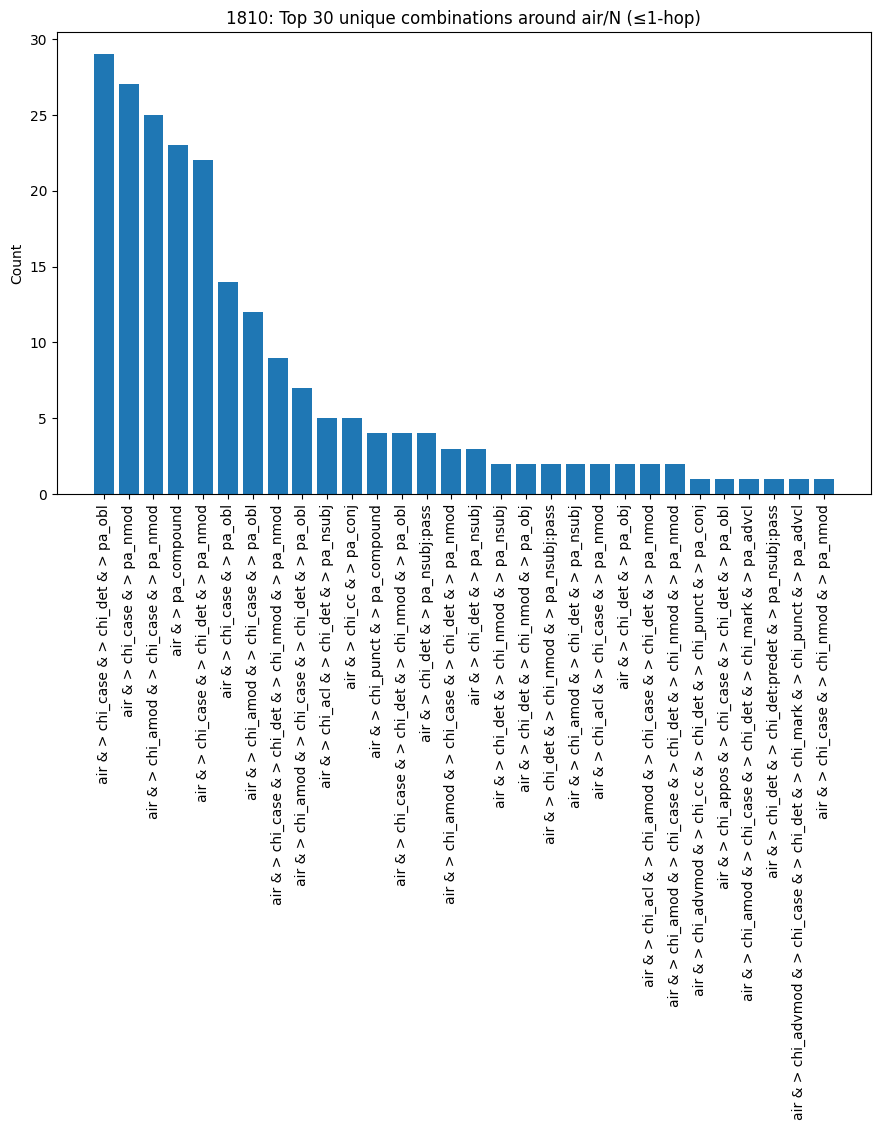

[1815] Total instances: 418, distinct patterns: 92


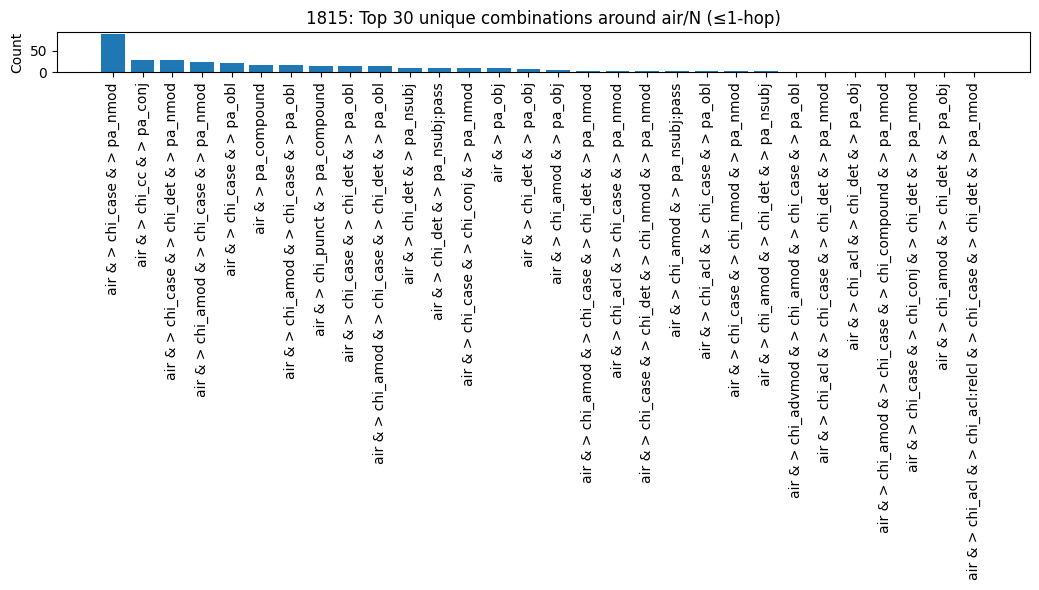

CSV saved to /home/volt/bach/SynFlow/output/air-N-1750-1819/Explorer/air_N_spath_combs_1_hops.csv


In [12]:
# 1 unique full-pattern string for 1 token
from SynFlow.Explorer import spath_comb_explorer

ctr = spath_comb_explorer(
    corpus_folder=corpus_folder,
    target_lemma=target_lemma,
    target_pos=target_pos,
    max_length=1,
    top_n=30,
    output_folder=output_explorer,
    pattern=pattern
)

## Rel Explorer

In [13]:
from SynFlow.Explorer import rel_explorer

rel_explorer_results = rel_explorer(
    corpus_folder=corpus_folder,
    pattern=pattern,            # or leave None to use default
    target_lemma=target_lemma,
    target_pos=target_pos,
    rel="pa_obl:agent",
)

# inspect a few
# for sent, ctx_list, path in triples[:10]:
#     print(f"{path:>15}  {' > '.join(ctx_list):20} | {sent}")

for fname, sent, ctx_list, path in rel_explorer_results[:1000]:
    # ctx_list là một list các "lemma/pos", nối bằng ' > ' để in cho dễ nhìn
    ctx_chain = " > ".join(ctx_list)
    print(f"{fname:20} | {path:15} | {ctx_chain:20} | {sent}")

# Save to csv
import csv
out_path = f'{output_explorer}/rel_explorer.csv'
with open(out_path, "w", encoding="utf-8", newline="") as f:
    w = csv.writer(f, delimiter='\t')
    w.writerow(["file", "path", "ctx_nodes", "sentence"])
    for fname, sent, ctx_nodes, path in rel_explorer_results:
        ctx_chain = " > ".join(ctx_nodes)
        w.writerow([fname, path, ctx_chain, sent])

Royal_Society_Corpus_open_v6.0_text_105082_1751.txt | pa_obl:agent    | exert/V              | It is evident , that the larger the * hole is , over which the bladder is laid , a proportionably greater force is exerted upon it by the included air , in order to lift it up ; but the aperture of the hole can not be made very large , because the pressure of the incumbent air would either burst the valve , or so far force it down into the cavity , as to prevent its lying flat and close upon the plate , which is absolutely necessary .
Royal_Society_Corpus_open_v6.0_text_105082_1751.txt | pa_obl:agent    | press/V              | The consequence of this construction is , that when the piston is put down to the bottom of the cylinder , the air in the lodgment under the piston will evacuate itself so much the more , as the valve of the piston opens more easily , when pressed by the rarefied air above it , than when pressed by the whole weight of the atmosphere .
Royal_Society_Corpus_open_v6.0_tex

## Full Rel Explorer

In [14]:
from SynFlow.Explorer import full_rel_explorer

triples = full_rel_explorer(
    corpus_folder=corpus_folder,
    pattern=pattern,            # or leave None to use default
    target_lemma=target_lemma,
    target_pos=target_pos,
    rel="chi_case & chi_det & pa_obl",
    # rel="chi_aux & chi_nsubj & chi_obj & chi_punct",
    # rel="chi_discourse > chi_punct & chi_punct",
    mode = 'close', # 'open', 'close', 'closeh'
)

print(len(triples))

# inspect a few
for fname, sent, found_paths_details_list in triples[:10]:
    # found_paths_details_list is a list of (ctx_nodes, path_str) tuples
    for ctx_nodes, path_str in found_paths_details_list:
        # ctx_nodes is a list of "lemma/pos", join using ' > ' to print
        ctx_chain = " > ".join(ctx_nodes)
        print(f"{fname:20} | {path_str:15} | {ctx_chain:20} | {sent}")

# Save to csv
import csv
out_path = f'{output_explorer}/full_rel_explorer.csv'
with open(out_path, "w", encoding="utf-8", newline="") as f:
    w = csv.writer(f, delimiter='\t')
    w.writerow(["file", "path", "ctx_nodes", "sentence"])
    for fname, sent, ctx_nodes, path in rel_explorer_results:
        ctx_chain = " > ".join(ctx_nodes)
        w.writerow([fname, path, ctx_chain, sent])

582
Royal_Society_Corpus_open_v6.0_text_105139_1753.txt | chi_case        | in/A                 | At the same time I put a haddock into a pot of lime - water , and did the same with a piece of beef : at the same time I hung a fish and a bit of flesh in the air .
Royal_Society_Corpus_open_v6.0_text_105139_1753.txt | chi_det         | the/D                | At the same time I put a haddock into a pot of lime - water , and did the same with a piece of beef : at the same time I hung a fish and a bit of flesh in the air .
Royal_Society_Corpus_open_v6.0_text_105139_1753.txt | pa_obl          | hang/V               | At the same time I put a haddock into a pot of lime - water , and did the same with a piece of beef : at the same time I hung a fish and a bit of flesh in the air .
Royal_Society_Corpus_open_v6.0_text_105166_1753.txt | chi_case        | with/A               | He was perfectly satisfied that the experiments were fairly made , and that the explosion was much greater when the appar

## Trimming

In [15]:
import pandas as pd
df = pd.read_csv('/home/volt/bach/SynFlow/output/air-N-1750-1819/Explorer/air_N_spath_combs_1_hops.csv', sep='&')
df.head(10)

,Subfolder,Frequency,Target,Slot1,Slot2,Slot3,Slot4,Slot5,Slot6,Slot7,Slot8,Slot9,Slot10
0,1750,29,air,> chi_case,> chi_det,> pa_obl,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1750,27,air,> chi_case,> chi_det,> pa_nmod,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1750,16,air,> chi_det,> pa_nsubj,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1750,16,air,> chi_punct,> pa_compound,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1750,13,air,> chi_case,> pa_nmod,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,1750,11,air,> chi_amod,> chi_case,> chi_det,> pa_obl,NaN,NaN,NaN,NaN,NaN,NaN
6,1750,10,air,> chi_det,> pa_nsubj:pass,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,1750,7,air,> chi_det,> pa_obj,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,1750,7,air,> chi_amod,> chi_punct,> pa_appos,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,1750,5,air,> chi_det,> chi_nmod,> pa_nsubj,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
from SynFlow.Explorer import trim_and_merge
df_file = '/home/volt/bach/SynFlow/output/air-N-1750-1819/Explorer/air_N_spath_combs_1_hops.csv'
trimmed_rels = ['chi_case']
trim_and_merge(df_file=df_file, trimmed_rels=trimmed_rels)

Saved merged file to /home/volt/bach/SynFlow/output/air-N-1750-1819/Explorer/air_N_spath_combs_1_hops_trimmed.csv


,Subfolder,Frequency,Target,Slot_1,Slot_2,Slot_3,Slot_4,Slot_5,Slot_6,Slot_7,Slot_8,Slot_9
0,1750,29,air,> chi_det,> pa_obl,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1750,27,air,> chi_det,> pa_nmod,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1750,16,air,> chi_det,> pa_nsubj,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1750,16,air,> chi_punct,> pa_compound,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1750,13,air,> pa_nmod,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
2337,1815,1,air,> chi_nummod,> pa_nmod,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2338,1815,1,air,> chi_punct,> pa_conj,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2339,1815,1,air,> chi_punct,> pa_nmod,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2340,1815,1,air,> pa_nsubj,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Specialisations Grouping

In [24]:
from SynFlow.Explorer.trimming import spe_group

df_path = '/home/volt/bach/SynFlow/output/air-N-1750-1819/Explorer/air_N_spath_combs_1_hops.csv'
tree = spe_group(df_path, output_folder=output_explorer, target_lemma=target_lemma)

Saved to /home/volt/bach/SynFlow/output/air-N-1750-1819/Explorer/air_spath_comb_grouped.json


# Get Slot-filler df

In [21]:
from SynFlow.Explorer import build_sfiller_df

df_slots = build_sfiller_df(
    corpus_folder=corpus_folder,
    template='[chi_amod]', # Example: '[chi_nsubj][chi_obj][chi_obl > chi_case]'
    target_lemma=target_lemma,
    target_pos=target_pos,
    pattern=pattern,
    # freq_path='/home/volt/bach/pilot_data/RSC/lemma_pos_init_freq.txt', # Be sure that the freq_path matches that of the filter format
    # freq_min=1,
    # freq_max=100_000_000,
    filtered_pos=[],
    filler_format='lemma/pos', # lemma/deprel or 'lemma/pos'
    output_folder= output_embedding
)

Wrote slot‐fillers to /home/volt/bach/SynFlow/output/air-N-1750-1819/Embedding/air_samples_sfillerdf_all.csv (6627 rows), dropped 6832 tokens.


In [22]:
# Sampling from the general slots DataFrame
from SynFlow.Explorer import sample_sfiller_df
n = 5
df_sample = sample_sfiller_df(
    input_csv=f"{output_embedding}/{target_lemma}_samples_sfillerdf_all.csv",
    output_csv=f"{output_embedding}/{target_lemma}_samples_sfillerdf_{n}.csv",
    n=n,
    seed=42,
    mode= 'NA'
)

Sampled 70 rows from /home/volt/bach/SynFlow/output/air-N-1750-1819/Embedding/air_samples_sfillerdf_all.csv → /home/volt/bach/SynFlow/output/air-N-1750-1819/Embedding/air_samples_sfillerdf_5.csv


In [ ]:
# template='[chi_nsubj][chi_obj][chi_obl > chi_case]'
# slots     = template.strip("[]").split("][")
# print(slots)